<a href="https://it-omscholing.nl/locaties/hogeschool-rotterdam/">
<div>
<img src='../../pics/banner.PNG'/>
</div>
<div>
<a href=''><img src='../../pics/miw.PNG'/></a>
<em>Author: Jeroen Boogaard</em>
</div>
</a>

<h1>Practicum Computer Vision</h1>

<h2>Doel: Image Processing voor het vereenvoudigen van <i>Features</i></h2>

<img src='../../pics/land_use.png' length=40% width=40%>

<h3>Imports</h3>

In [1]:
from image_filter import ImageFilter
from PIL import Image
import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import random
import skimage.measure
import scipy as sp

<h3>Globale variabelen</h3>

In [2]:
riverDirectory = '../../pics/2750/River'
highwayDirectory = '../../pics/2750/Highway'

<h3>Data Collection</h3>
<p>
We gebruiken Images uit de <a href="https://www.kaggle.com/datasets/apollo2506/eurosat-dataset">EuroSat dataset</a> die gemaakt zijn met de Sentinel-2 sateliet. Elke image is een 64x64 pixels foto van Europees aardoppervlak op een hoogte van 10 meter. De images zijn te categoriseren in Highway, Industrial, Pasture, PermanentCrop, Residential, River en SeaLake.
</p>
<img src=../../pics/eurosat_overview_small.jpg length=50% width=50%>
<p>
Download <a href="http://madm.dfki.de/files/sentinel/EuroSAT.zip">EuroSAT.zip</a> en kopieer daaruit de directory 2750 naar opdrachten/practica/pics.      
<strong>Voeg het pad naar de directory 2750 toe aan .gitignore zodat je de plaatjes niet naar je remote git repository pusht</strong>
</p>    

<h3>Data Selection</h3>

In [3]:
# die heb je hier nog niet
# display(len(edgeFiles))

In [4]:
edgeFiles = list()

In [5]:
for filename in os.listdir(riverDirectory):
    imgFile = os.path.join(riverDirectory, filename)

    if ".jpg" in imgFile:
        edgeFiles.append(imgFile)

<h3>Exercise 1</h3>
<p>
    Voeg de directory Highway toe aan de <u>list</u> edgeFiles zodat ook de Highway images worden meegenomen. 
</p>

In [6]:
# Oplossing 

for filename in os.listdir(highwayDirectory):
    imgFile = os.path.join(highwayDirectory, filename)

    if ".jpg" in imgFile:
        edgeFiles.append(imgFile)

<h3>Data Transform</h3>
<p>
Image filters zijn Tensors en om die toe te kunnen passen zetten we de images eerst om naar Tensors m.b.v. Numpy.
</p>    

In [7]:

imageTensors = [ plt.imread(pic).astype(float) for pic in edgeFiles ]
nrOfImages = len(imageTensors)

In [8]:
display(nrOfImages)

5000

<h4>Data Normalising</h4>
<p>Om waardes tussen 0 en 1 te verkrijgen, delen we door de maximale pixelwaarde</p>

In [9]:
imageTensors = [ imageTensor/255 for imageTensor in imageTensors ]

<p>
De tensors bevatten alleen de numerieke data van de images, om die te kunnen herleiden tot de oorspronkelijke images hebben we ook een lijst met de corresponderende labels nodig. De labels kunnen we afleiden uit de bestandsnamen.    
</p>    

In [39]:
labelNames, labelNumbers = ([], [])

for i, fileName in enumerate(edgeFiles):
    labelNames.append(fileName.split('/')[5])
    labelNumbers.append(i)
    # waarbij [5] de 5e slash is die je weghaalt. Nu moetje de .jpg nog verwijderen.
    # patlib gebruiken ipv 4 in 5 veranderen
print(labelNames[0])
print(edgeFiles[0])

River_424.jpg
../../pics/2750/River/River_424.jpg


**Controleer de data**

In [40]:
print(f"De eerste Image heeft label {labelNames[0]}")
print(f"De laatste Image heeft label {labelNames[nrOfImages-1]}")

De eerste Image heeft label River_424.jpg
De laatste Image heeft label Highway_2396.jpg


<h3>Data visualiseren</h3>

In [12]:
def showImages():
    
    plt.figure(figsize=(10,10))
    
    for i in range(4):
        
        # Maak een 2 x 2 raster van Images
        plt.subplot(2, 2, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)        
                
        # Van Tensor terug naar Image
        plt.imshow(imageTensors[i])
        
        # Bijbehorende Imagelabel
        plt.xlabel( f"{labelNames[labelNumbers[i]]} {labelNumbers[i]}" ) 

    plt.show()           

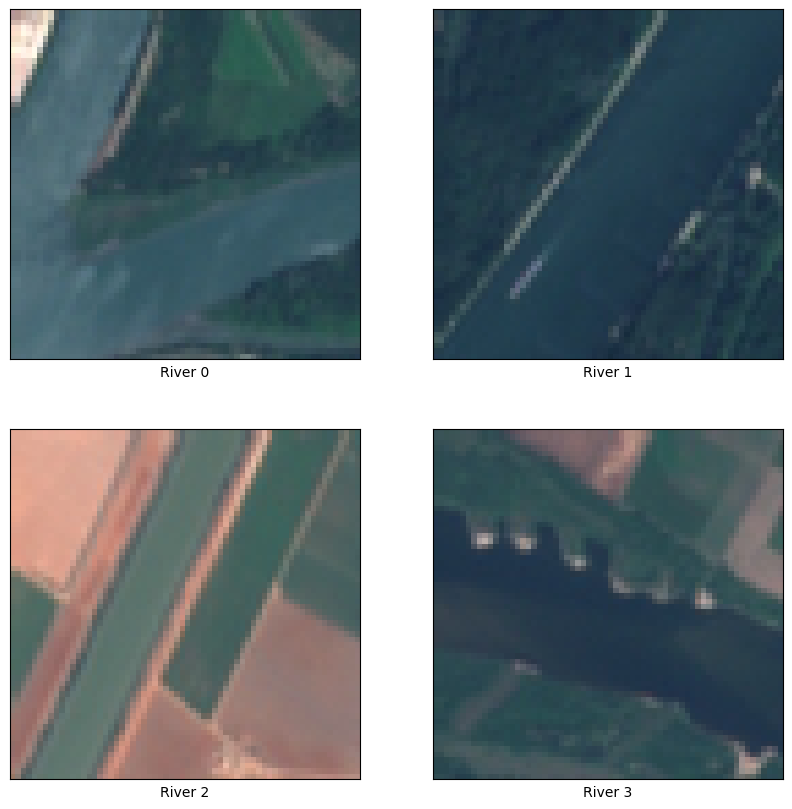

In [13]:
showImages() 

<h3>Exercise 2</h3>
<p>
Maak een nieuwe functie <u>showRandomImages()</u> die <u>16 random</u> images uit de dataset selecteert en weergeeft in een 4 x 4 raster<br>
<strong>Let erop dat bij iedere image het corresponderende label getoond wordt</strong>
</p>

In [14]:
# Oplossing   

def showRandomImages():
    
    plt.figure(figsize=(10,10))
    
    for i in range(16):
        
        # Maak een 4 x 4 raster van Images
        plt.subplot(4, 4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)        
                
        # Van Tensor terug naar Image
        randInd = random.randint(0, nrOfImages)
        
        plt.imshow(imageTensors[randInd])
        
        # Bijbehorende Imagelabel
        plt.xlabel( f"{labelNames[labelNumbers[i]]} {labelNumbers[i]}" ) 

    plt.show() 
    
# met teruglegging dus in principe kan je 2 x hetzelfde plaatje pakken. Als je dat er wel uithaalt, dan kan je een missing plaatje en kleiner aantal dan 5000 krijgen.

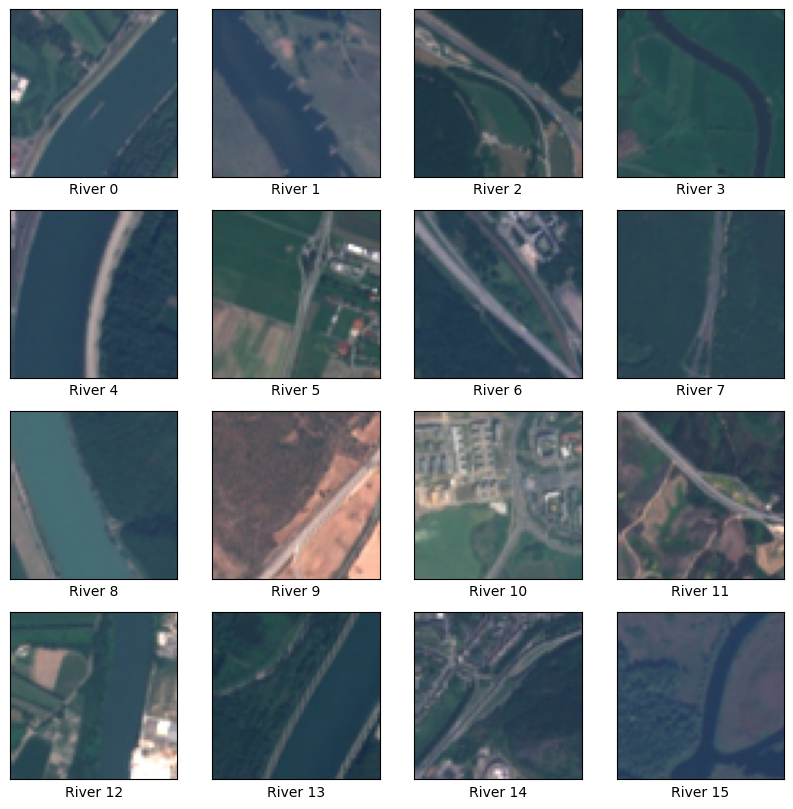

In [15]:
showRandomImages()

<h4>Edge Detection</h4>
<p>
Zowel de Highway en River Images hebben randen die relevant zijn om de auto- of waterweg te kunnen onderscheiden van de directe omgeving. We gaan daarom zoveel mogelijk niet-relevante informatie wegfilteren.    
</p>    

<p>Functie voor het genereren van een subplot</p>

In [16]:
def plotImgs(lImg, rImg):
    plt.style.use('dark_background') 
    plt.rcParams["font.size"] = 12
    plt.rcParams["figure.figsize"] = (12, 7)

    fig, (axL, axR) = plt.subplots(ncols=2, constrained_layout=True)
    fig.suptitle(f"{labelNames[labelNumbers[randInd]]} {labelNumbers[randInd]}")
    imL = axL.imshow(np.clip(lImg, 0, 1), interpolation="none")
    imR = axR.imshow(np.clip(rImg, 0, 1), interpolation="none")    

**Definieer de Image Kernel voor het convolutiefilter**

In [17]:
isoTropicFilter = ImageFilter( 
    np.array (
        [
            [-1, -1, -1], 
            [-1,  8, -1], 
            [-1, -1, -1]
        ]
    ) 
)

# isoTropic wil zeggen rotation invariant. Linksom of rechtsom draaien geeft hetzelfde resultaat.
# wat geburt er met andere getallen? Hier is het 8 + -1 is een verschil van 10. Versterken en verzwakken in gelijke mate.

**Filter de Image**

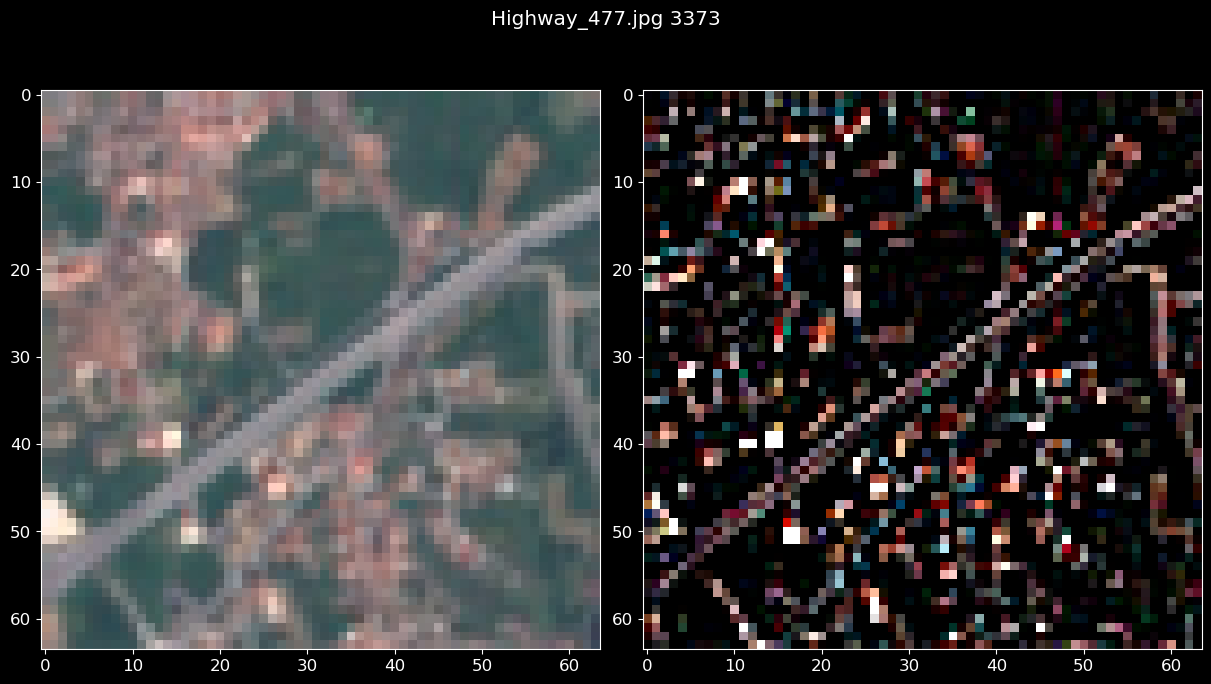

In [41]:
randInd = random.randint(0, nrOfImages)
imgOrg = imageTensors[randInd]
imgFiltered = isoTropicFilter.convolve(imgOrg)

plotImgs(imgOrg, imgFiltered)

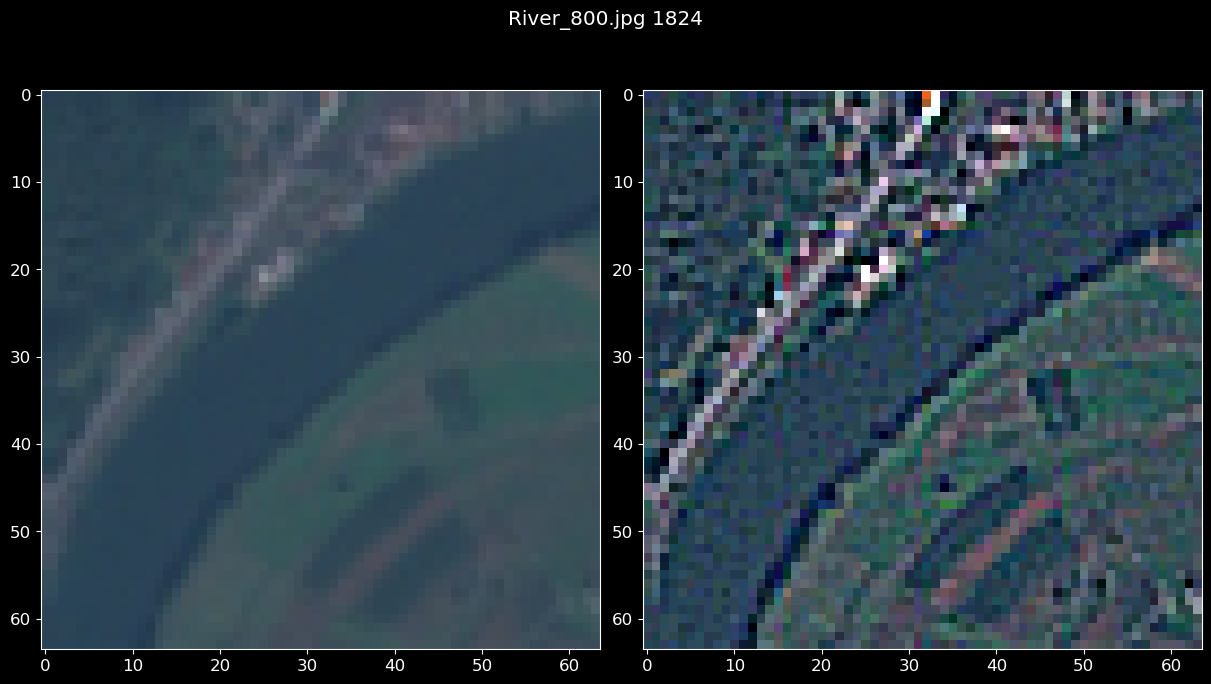

In [49]:
randInd = random.randint(0, nrOfImages)
imgOrg = imageTensors[randInd]
imgFiltered = isoTropicFilter.convolve(imgOrg)

plotImgs(imgOrg, (imgFiltered+imgOrg))

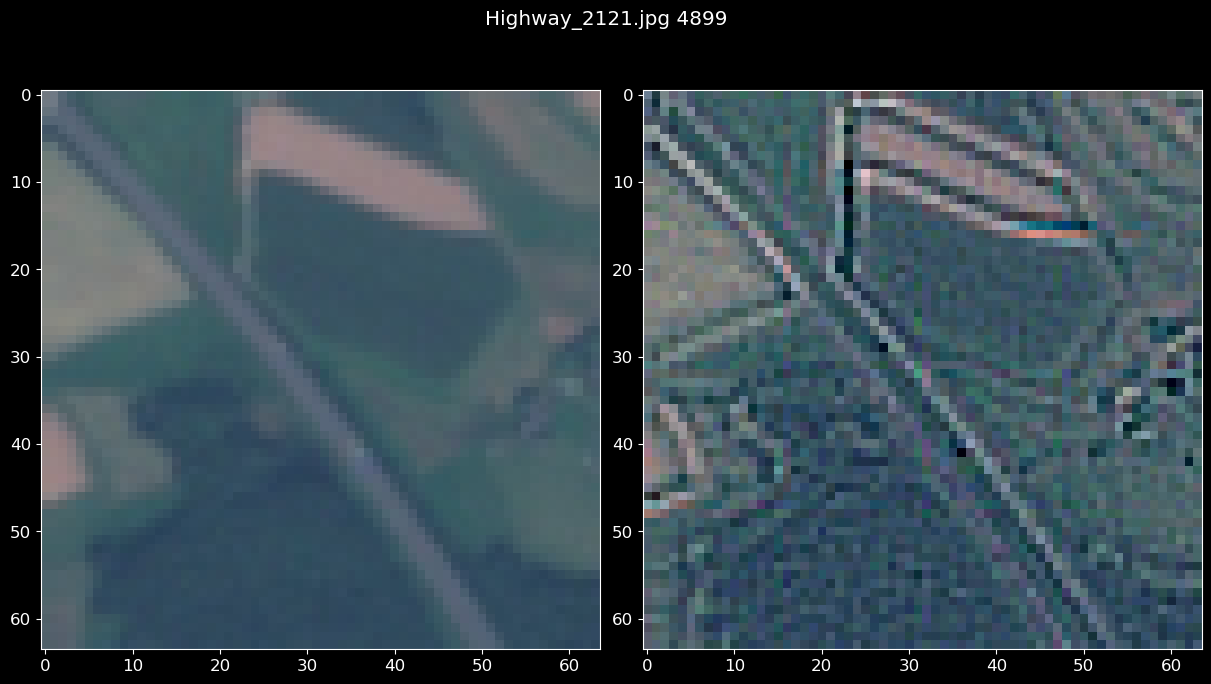

In [50]:
randInd = random.randint(0, nrOfImages)
imgOrg = imageTensors[randInd]
imgFiltered = isoTropicFilter.convolve(imgOrg)

plotImgs(imgOrg, (imgOrg-imgFiltered))

<h3>Exercise 3</h3>
<p>
    Maak een 3x3 ImageFilter object <u>horEdgeFilter</u> (een horizontal edge filter) en voer daarmee een aantal Convoluties uit.<br> 
    Vergelijk de resultaten met die van de Convoluties met de <u>isoTropicFilter</u>
    <br>N.B. de class ImageFilter roep je op uit het bestand image_filter.py in dezelfde map.
</p>
<p>
    <strong>Tips</strong>
    <ul>
        <li>Op <a href="https://en.wikipedia.org/wiki/Kernel_(image_processing)">Wikipedia</a> kun je verschillende filters vinden.<br>N.B. hier staan voorbeelden van filters. Echter, het gevraagde filter staat er niet bij! In de vorige notebook over numpy staat het filter als voorbeeld.</li>
        <li>Schrijf een functie voor de <i>batchverwerking</i> van Images.</li>
    </ul>
</p>

In [42]:
# Oplossing filter

horEdgeFilter = ImageFilter( 
    np.array (
        [
            [1, 2, 1], 
            [0,  0, 0], 
            [-1, -2, -1]
        ]
    ) 
)

# 1,1,1 vervangen door 1,2,1 en ook bij onderste rij

In [20]:
# Oplossing batchverwerking

# verder niet uitgewerkt, maar je kan een functie maken van het veld hieronder en dan met een loop die functie enkele keren aanroepen, om random image te genereren.

ImageFilter(horEdgeFilter)

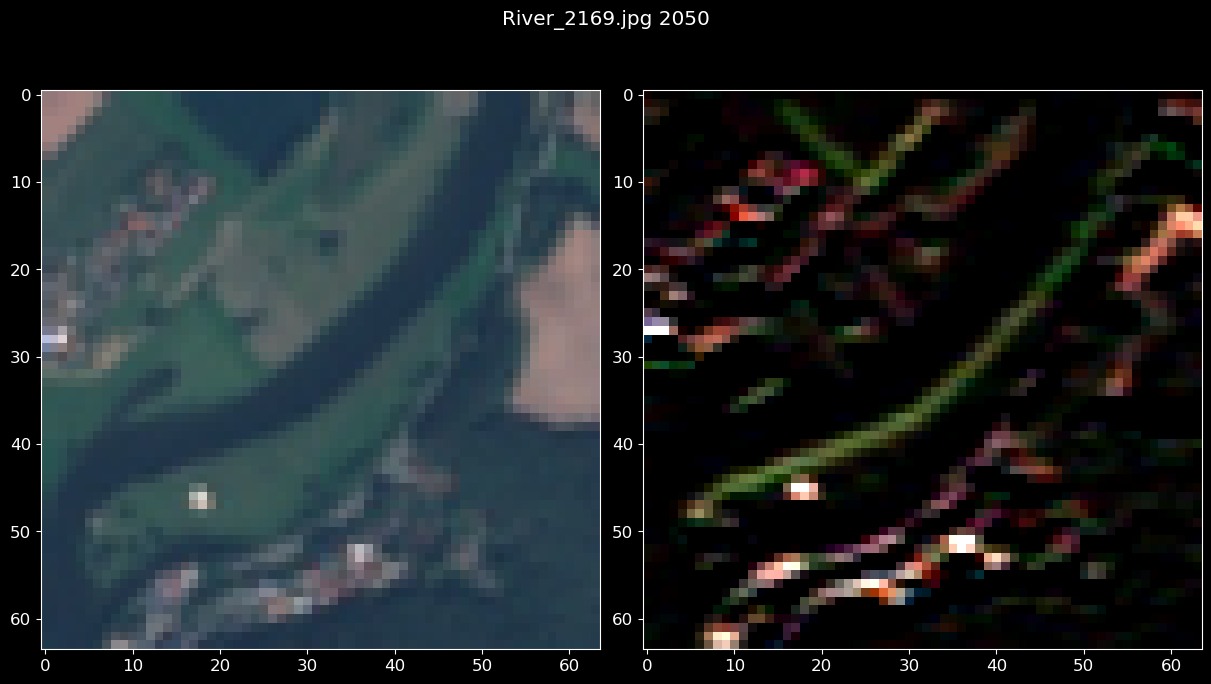

In [45]:
randInd = random.randint(0, nrOfImages)
imgOrg = imageTensors[randInd]
imgFiltered = horEdgeFilter.convolve(imgOrg)

plotImgs(imgOrg, imgFiltered)

<h3>Exercise 4</h3>
<p>
Voeg aan class ImageFilter de methode <u>downSample()</u> toe waarmee een Image gedownsampled kan worden. Maak gebruik van <a href="https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.block_reduce">block_reduce</a> met een grootte van 2.
</p>

In [23]:
# Oplossing

# my_image_filter.py aangemaakt en daar def downSample toegevoegd

from my_image_filter import MyImageFilter


In [24]:
# aanroepen functie, wordt gebruikt voor max en mean pooling.

MyImageFilter(isoTropicFilter)

In [25]:
myIsoTropicFilter = MyImageFilter( 
    np.array (
        [
            [-1, -1, -1], 
            [-1,  8, -1], 
            [-1, -1, -1]
        ]
    ) 
)

In [33]:
myPoolFilter = MyImageFilter()

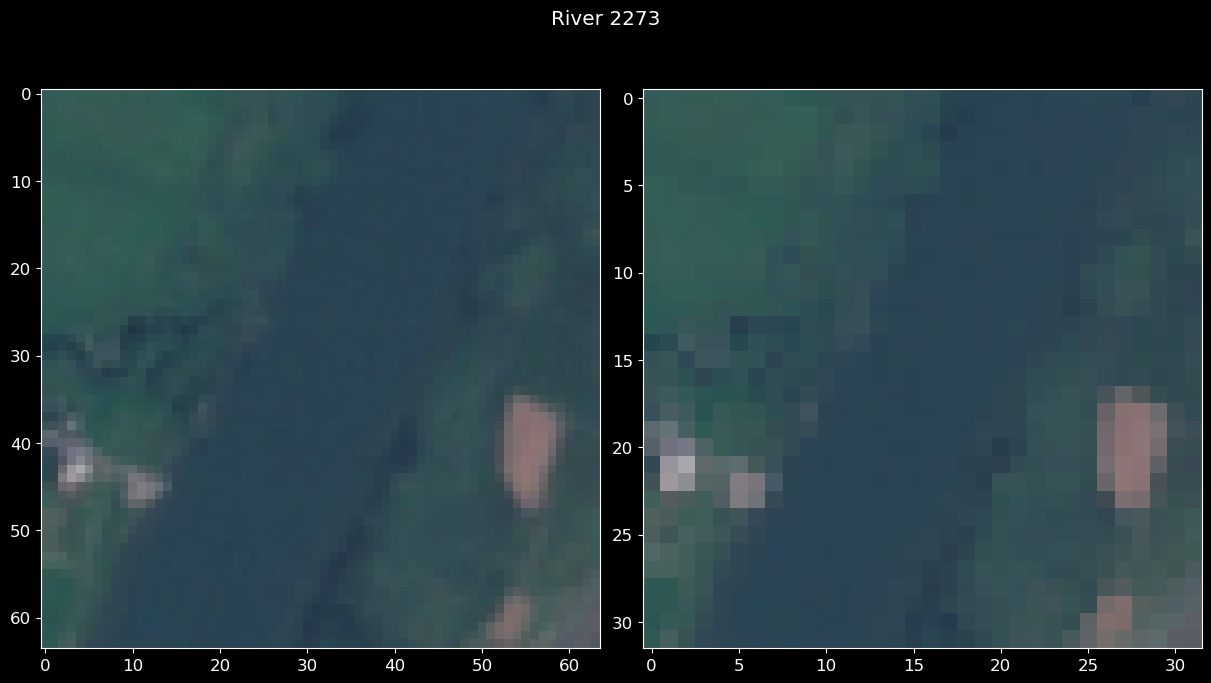

In [32]:
# randInd = random.randint(0, nrOfImages)
imgOrg = imageTensors[42]
imgFiltered = myIsoTropicFilter.downSample(imgOrg)

plotImgs(imgOrg, imgFiltered)

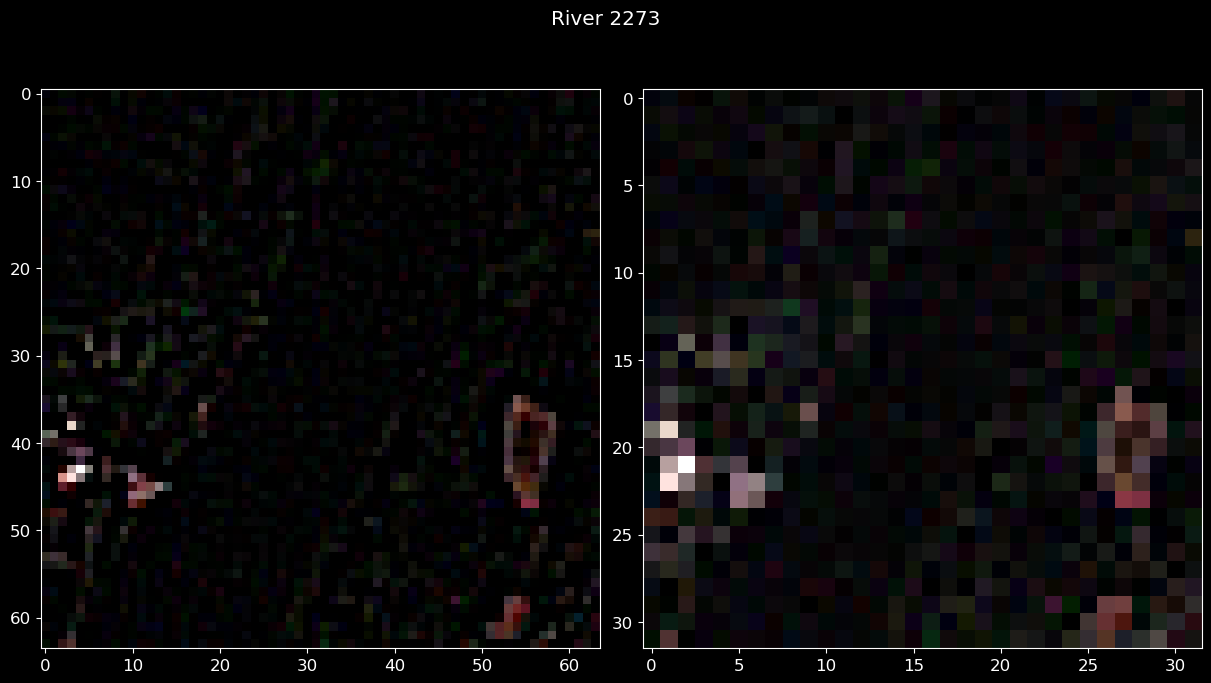

In [35]:
# randInd = random.randint(0, nrOfImages)
imgOrg = imageTensors[42]
imgFiltered = myIsoTropicFilter.convolve(imgOrg)
imgPooled = myPoolFilter.downSample(imgFiltered)

plotImgs(imgFiltered,imgPooled)

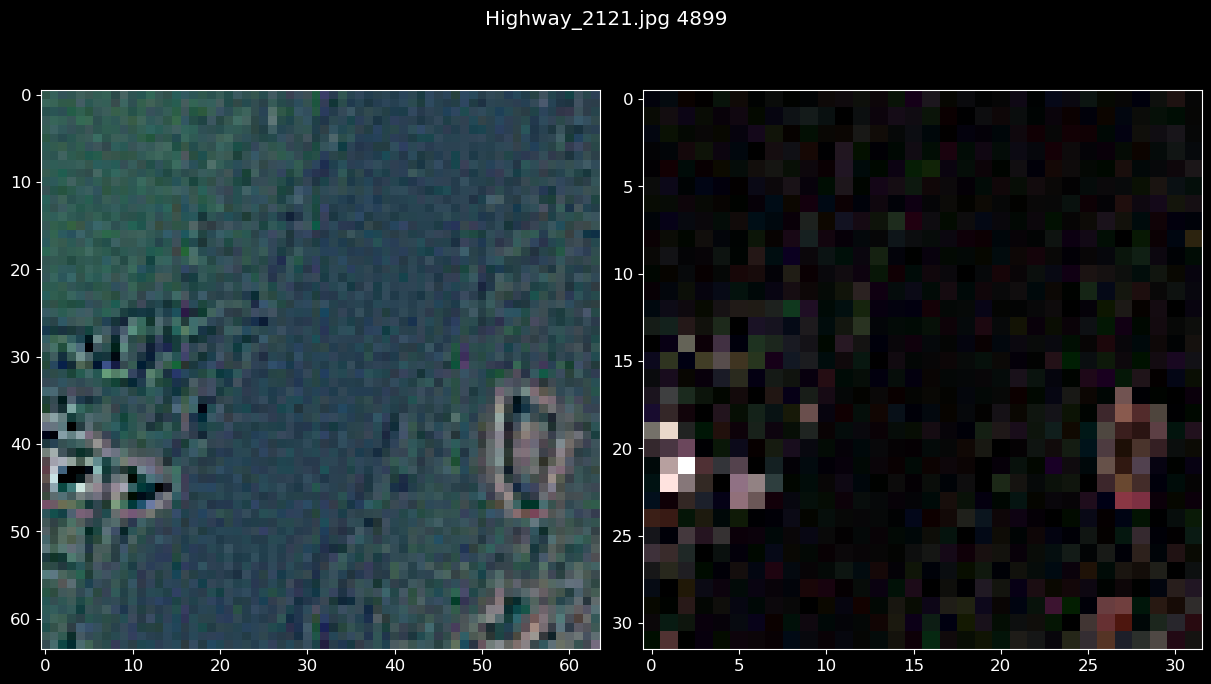

In [52]:
# randInd = random.randint(0, nrOfImages)
imgOrg = imageTensors[42]
imgFiltered = myIsoTropicFilter.convolve(imgOrg)
imgPooled = myPoolFilter.downSample(imgFiltered)

plotImgs(imgOrg-imgFiltered,imgPooled)

In [29]:
print(imgFiltered.shape)

(32, 32, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

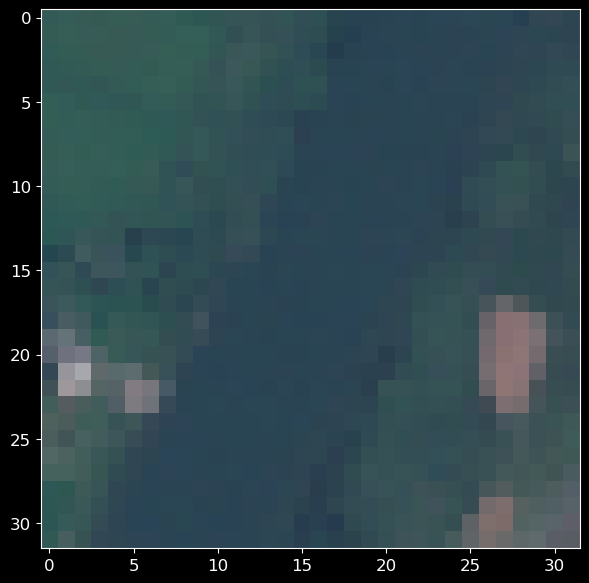

In [30]:
plt.imshow(imgFiltered)
plt.show

# Je ziet dat de image kleiner is. Schrijf hem nu weg als een file en kijk naar de grootte.

<h2>References</h2>

[Image Kernels Explained Visuall - Victor Powell](https://setosa.io/ev/image-kernels/)<br>